In [ ]:
import torch

sample_size = 0.3  # Original is 0.3

use_val_set = False

device = "cuda" if torch.cuda.is_available() else "cpu"
onnx_path = "autoencoder.onnx"

trained_model_path = "../../../autoencoder/autoencoder.pth"

existing_model_architecture = {
    "input_dim": 15,
    "hidden_dims": [13, 11],
    "latent_dim": 9,
    "activation_type": "ReLU",
    "negative_slope": 1,
    "output_activation_type": "Sigmoid",
}

train_set_path = "../../../datasets/train_set.csv"
test_set_path = "../../../datasets/test_set.csv"

In [2]:
dbscan_parameters = {
    "eps": 0.103615594461271,
    "min_samples": 12,
    "distance_metric": "manhattan",
    "score": 0.961629569530487,
}

tree_alogrithm_parameter = "ball_tree"

dbocsvm_parameter_list = {
    0: {"kernel": "rbf", "gamma": 0.9953872263076934, "nu": 0.45174021431898825},
    1: {"kernel": "rbf", "gamma": 0.4393193624570486, "nu": 0.061463139892629075},
    2: {"kernel": "rbf", "gamma": 0.5516811847699685, "nu": 0.02075979638179337},
    3: {"kernel": "rbf", "gamma": 0.6870644343013828, "nu": 0.15551475411368967},
    4: {"kernel": "rbf", "gamma": 0.5818128997730962, "nu": 0.3262387446702137},
    5: {"kernel": "rbf", "gamma": 0.0001302592349372196, "nu": 0.43530445271206786},
    6: {"kernel": "rbf", "gamma": 0.5115592226353691, "nu": 0.3638097358322278},
    7: {"kernel": "rbf", "gamma": 0.4237672306259186, "nu": 0.0328360236321898},
    8: {"kernel": "rbf", "gamma": 0.12201112468927489, "nu": 0.35169805867789355},
    9: {"kernel": "rbf", "gamma": 0.9919163894561822, "nu": 0.2642750371347232},
    10: {"kernel": "rbf", "gamma": 0.5530889245549419, "nu": 0.34532949607450164},
    11: {"kernel": "rbf", "gamma": 0.9494341933951694, "nu": 0.13308739503816708},
    12: {"kernel": "rbf", "gamma": 0.8348880228391921, "nu": 0.17633925484334115},
    13: {"kernel": "rbf", "gamma": 0.0012177918247914532, "nu": 0.27262852147217526},
    14: {"kernel": "rbf", "gamma": 0.3601942487696086, "nu": 0.171549003721742},
    15: {"kernel": "rbf", "gamma": 0.030671303251142708, "nu": 0.4042294965783453},
    16: {"kernel": "rbf", "gamma": 0.9499018027446345, "nu": 0.34908748578494675},
    17: {"kernel": "rbf", "gamma": 0.7417158150634153, "nu": 0.03219010478240265},
    18: {"kernel": "rbf", "gamma": 0.9276362880607424, "nu": 0.1336970758038835},
    19: {"kernel": "rbf", "gamma": 0.5265848014172256, "nu": 0.3628180350864216},
    20: {"kernel": "rbf", "gamma": 0.5342191718877597, "nu": 0.37574611945493985},
    21: {"kernel": "rbf", "gamma": 0.5957445760227565, "nu": 0.060354964244621195},
    22: {"kernel": "rbf", "gamma": 0.4812093473112323, "nu": 0.02801851633132623},
    23: {"kernel": "rbf", "gamma": 0.8636653347391009, "nu": 0.10896764550294757},
    24: {"kernel": "rbf", "gamma": 0.9395511865093198, "nu": 0.1630967391717133},
    25: {"kernel": "rbf", "gamma": 0.6774614702559713, "nu": 0.1186885072722749},
    26: {"kernel": "rbf", "gamma": 0.8891743983146955, "nu": 0.05979443189839137},
    27: {"kernel": "rbf", "gamma": 0.9744371313583867, "nu": 0.23861873546528262},
    28: {"kernel": "rbf", "gamma": 0.5311912023101605, "nu": 0.16769884188079098},
}

load trained autoencoder

In [3]:
from autoencoder import BatchNormAutoencoder

autoencoder = BatchNormAutoencoder(
    input_dim=existing_model_architecture["input_dim"],
    hidden_dims=existing_model_architecture["hidden_dims"],
    latent_dim=existing_model_architecture["latent_dim"],
    activation_type=existing_model_architecture["activation_type"],
    negative_slope=existing_model_architecture["negative_slope"],
    output_activation_type=existing_model_architecture["output_activation_type"],
)

In [4]:
# Load best model
checkpoint = torch.load(trained_model_path)
autoencoder.load_state_dict(checkpoint["model_state_dict"])

autoencoder.eval()

BatchNormAutoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=15, out_features=13, bias=True)
    (1): BatchNorm1d(13, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=13, out_features=11, bias=True)
    (4): BatchNorm1d(11, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=11, out_features=9, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=9, out_features=11, bias=True)
    (1): BatchNorm1d(11, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=11, out_features=13, bias=True)
    (4): BatchNorm1d(13, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=13, out_features=15, bias=True)
    (7): Sigmoid()
  )
)

In [5]:
# Function to export model to ONNX format
def export_to_onnx(model, input_dim, file_path):
    model.eval()
    # Create dummy input tensor for ONNX export
    dummy_input = torch.randn(1, input_dim, device=device)

    # Export the model
    torch.onnx.export(
        model,  # model being run
        dummy_input,  # model input (or a tuple for multiple inputs)
        file_path,  # where to save the model
        export_params=True,  # store the trained parameter weights inside the model file
        opset_version=17,  # the ONNX version to export the model to
        do_constant_folding=True,  # whether to execute constant folding for optimization
        input_names=["input"],  # the model's input names
        output_names=["output"],  # the model's output names
        dynamic_axes={
            "input": {0: "batch_size"},  # variable length axes
            "output": {0: "batch_size"},
        },
    )
    print(f"Model exported to ONNX: {file_path}")

In [6]:
import os

os.makedirs("saved_models/onnx", exist_ok=True)

onnx_path = "saved_models/onnx/autoencoder_proposed_cidds_001.onnx"

export_to_onnx(autoencoder, existing_model_architecture["input_dim"], onnx_path)

Model exported to ONNX: saved_models/onnx/autoencoder_proposed_cidds_001.onnx


In [7]:
def export_encoder_to_onnx(model, input_dim, file_path):
    model.eval()
    # Create dummy input tensor for ONNX export
    dummy_input = torch.randn(1, input_dim, device=device)

    # Create a wrapper class that only calls the encode method
    class EncoderOnly(torch.nn.Module):
        def __init__(self, autoencoder):
            super(EncoderOnly, self).__init__()
            self.autoencoder = autoencoder

        def forward(self, x):
            return self.autoencoder.encode(x)

    encoder_only = EncoderOnly(model)

    # Export the encoder model
    torch.onnx.export(
        encoder_only,
        dummy_input,
        file_path,
        export_params=True,
        opset_version=17,
        do_constant_folding=True,
        input_names=["input"],
        output_names=["output"],
        dynamic_axes={
            "input": {0: "batch_size"},
            "output": {0: "batch_size"},
        },
    )
    print(f"Encoder model exported to ONNX: {file_path}")

In [8]:
# Export just the encoder part
encoder_onnx_path = "saved_models/onnx/autoencoder_encoder_cidds_001.onnx"
export_encoder_to_onnx(
    autoencoder, existing_model_architecture["input_dim"], encoder_onnx_path
)

Encoder model exported to ONNX: saved_models/onnx/autoencoder_encoder_cidds_001.onnx


In [9]:
import pandas as pd

train_df = pd.read_csv(train_set_path)

train_df = train_df.sample(frac=sample_size, random_state=42).reset_index(drop=True)

print(train_df.shape)
train_df.head(1)

(54000, 17)


,duration,packets,bytes,flows,tcp_urg,tcp_ack,tcp_psh,tcp_rst,tcp_syn,tcp_fin,tos,proto_ICMP,proto_IGMP,proto_TCP,proto_UDP,attack_binary,attack_categorical
0,0.001965,0.000032,0.000007,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1,benign


In [10]:
X_train = train_df.drop(columns=["attack_binary", "attack_categorical"]).values
y_train = train_df["attack_binary"].values

print(X_train.shape)

(54000, 15)


In [11]:
autoencoder.eval()

BatchNormAutoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=15, out_features=13, bias=True)
    (1): BatchNorm1d(13, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=13, out_features=11, bias=True)
    (4): BatchNorm1d(11, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=11, out_features=9, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=9, out_features=11, bias=True)
    (1): BatchNorm1d(11, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=11, out_features=13, bias=True)
    (4): BatchNorm1d(13, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=13, out_features=15, bias=True)
    (7): Sigmoid()
  )
)

In [12]:
import torch
from torch.utils.data import TensorDataset

# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train)

# Create data loaders
X_train_dataset = TensorDataset(X_train_tensor)

input_dim = X_train.shape[1]

Training the DBOCSVM

In [13]:
from torch.utils.data import DataLoader
import numpy as np

# extract encoded features
X_train_loader = DataLoader(X_train_dataset, batch_size=256)

# Extract in batches to prevent memory issues
X_train_full_encoded = []
with torch.no_grad():
    for data in X_train_loader:
        data_x = data[0].to(device)
        encoded = autoencoder.encode(data_x)
        X_train_full_encoded.append(encoded.cpu().numpy())
X_train_full_encoded = np.vstack(X_train_full_encoded)

In [14]:
print(f"eps = {dbscan_parameters["eps"]}")
print(f"min_samples = {dbscan_parameters["min_samples"]}")
print(f"metric = {dbscan_parameters["distance_metric"]}")

eps = 0.103615594461271
min_samples = 12
metric = manhattan


In [15]:
from db_ocsvm import DBOCSVM

dbocsvm = DBOCSVM(
    kernel="rbf",
    gamma="auto",
    nu=0.2,
    eps=dbscan_parameters["eps"],
    min_samples=dbscan_parameters["min_samples"],
    dbscan_distance_metric=dbscan_parameters["distance_metric"],
)

In [16]:
import time

# Start timer
start_time = time.time()
dbocsvm.fit_cluster(X_train_full_encoded, verbose=True)

Fitting DBSCAN...
DBSCAN Fitted...
Unique Clusters: [-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22
 23 24 25 26 27 28]
Cluster Sizes: {-1: 283, 0: 15666, 1: 11398, 2: 10639, 3: 6686, 4: 858, 5: 3568, 6: 51, 7: 2269, 8: 85, 9: 478, 10: 87, 11: 85, 12: 693, 13: 158, 14: 129, 15: 158, 16: 34, 17: 24, 18: 201, 19: 28, 20: 161, 21: 17, 22: 79, 23: 31, 24: 31, 25: 34, 26: 31, 27: 14, 28: 24}


In [17]:
dbocsvm.fit_ocsvm(X_train_full_encoded, parameter_list=dbocsvm_parameter_list)

# End timer
end_time = time.time()

In [18]:
training_time = end_time - start_time
print(f"Training time: {training_time:.6f} seconds")

Training time: 54.869669 seconds


save model

In [19]:
import joblib


# To save your fitted model
def save_dbocsvm_model(model, filename, compress=3):
    """
    Save a fitted DBOCSVM model to disk

    Parameters:
    -----------
    model : DBOCSVM
        The fitted model to save
    filename : str
        Path where the model will be saved
    compress : int, default=3
        Compression level (0-9)
    """
    joblib.dump(model, filename, compress=compress)


# To load your model
def load_dbocsvm_model(filename):
    """
    Load a DBOCSVM model from disk

    Parameters:
    -----------
    filename : str
        Path to the saved model file

    Returns:
    --------
    DBOCSVM
        The loaded model
    """
    return joblib.load(filename)


# Save the model
os.makedirs("saved_models/joblib", exist_ok=True)
model_path = "saved_models/joblib/dbocsvm_cidds_001.joblib"
save_dbocsvm_model(dbocsvm, model_path)

# Later, load the model
loaded_model = load_dbocsvm_model(model_path)

In [20]:
test_df = pd.read_csv(test_set_path)
print(test_df.shape)
print(test_df["attack_categorical"].value_counts())
test_df.head(1)

from sklearn.model_selection import train_test_split

test_df, val_df = train_test_split(
    test_df,
    test_size=0.5,
    random_state=42,
    stratify=test_df["attack_categorical"],
)

(20000, 17)
attack_categorical
benign        11226
dos            5564
portScan       1730
bruteForce      804
pingScan        676
Name: count, dtype: int64


In [21]:
if use_val_set:
    test_df = val_df

print("Test Set:", test_df.shape)

Test Set: (10000, 17)


In [22]:
# Splitting into X and y
X_test = test_df.drop(columns=["attack_binary", "attack_categorical"]).values
y_test = test_df["attack_binary"].values
y_test_class = test_df["attack_categorical"].values

In [23]:
from imblearn.over_sampling import SMOTE

if use_val_set:
    print("Using validation set for testing.")
    sampling_strategy = {
        "dos": 4000,
        "portScan": 4000,
        "bruteForce": 4000,
        "pingScan": 4000,
    }
    smote = SMOTE(random_state=42, k_neighbors=3, sampling_strategy=sampling_strategy)
    X_test, y_test_class = smote.fit_resample(X_test, y_test_class)
    y_test = np.where(y_test_class == "benign", 1, -1)

In [24]:
print(f"test set count: {test_df.shape[0]:,}")
print(f"unique values: {test_df['attack_categorical'].value_counts()}")
test_df.head(3)

test set count: 10,000
unique values: attack_categorical
benign        5613
dos           2782
portScan       865
bruteForce     402
pingScan       338
Name: count, dtype: int64


,duration,packets,bytes,flows,tcp_urg,tcp_ack,tcp_psh,tcp_rst,tcp_syn,tcp_fin,tos,proto_ICMP,proto_IGMP,proto_TCP,proto_UDP,attack_binary,attack_categorical
12406,0.000829,0.000075,4.657671e-06,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,-1,pingScan
15620,0.002278,0.000016,4.326256e-07,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,-1,dos
17951,0.000202,0.000021,1.103394e-06,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,-1,bruteForce


prediction on the model

In [25]:
X_test_tensor = torch.FloatTensor(X_test).to(device)
X_test_encoded = []

test_dataset = TensorDataset(X_test_tensor, torch.zeros(len(X_test_tensor)))
test_loader = DataLoader(test_dataset, batch_size=128)

with torch.no_grad():
    for data, _ in test_loader:
        encoded = autoencoder.encode(data)
        X_test_encoded.append(encoded.cpu().numpy())

X_test_encoded = np.vstack(X_test_encoded)
print(X_test_encoded.shape)

(10000, 9)


In [26]:
# Start timer
start_time = time.time()

In [27]:
y_pred = dbocsvm.predict(X_test_encoded)

In [28]:
y_pred_saved = loaded_model.predict(X_test_encoded)

In [29]:
# End timer
end_time = time.time()

In [30]:
# Calculate and print training time
training_time = end_time - start_time
print(f"Testing time: {training_time:.6f} seconds")

Testing time: 9.944676 seconds


evaluating the model

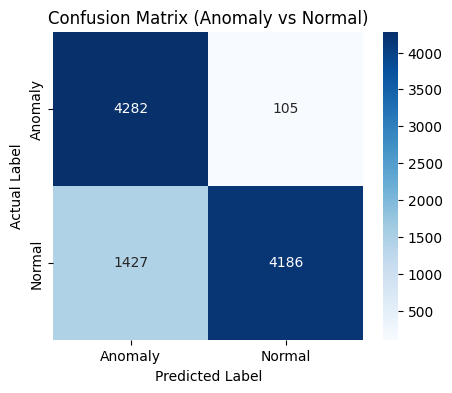

In [31]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred_saved, labels=[-1, 1])


def plot_confusion_matrix(cm, labels, title):
    plt.figure(figsize=(5, 4))
    sns.heatmap(
        cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels
    )
    plt.xlabel("Predicted Label")
    plt.ylabel("Actual Label")
    plt.title(title)
    plt.show()


plot_confusion_matrix(cm, ["Anomaly", "Normal"], "Confusion Matrix (Anomaly vs Normal)")

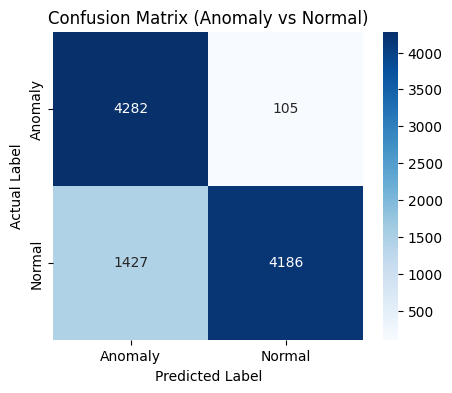

In [32]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred, labels=[-1, 1])


def plot_confusion_matrix(cm, labels, title):
    plt.figure(figsize=(5, 4))
    sns.heatmap(
        cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels
    )
    plt.xlabel("Predicted Label")
    plt.ylabel("Actual Label")
    plt.title(title)
    plt.show()


plot_confusion_matrix(cm, ["Anomaly", "Normal"], "Confusion Matrix (Anomaly vs Normal)")

In [33]:
from sklearn.metrics import (
    classification_report,
    precision_score,
    recall_score,
    f1_score,
    accuracy_score,
)

print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=["Anomaly", "Normal"]))

precision = precision_score(y_test, y_pred, pos_label=-1)
recall = recall_score(y_test, y_pred, pos_label=-1)
f1 = f1_score(y_test, y_pred, pos_label=-1)
acc = accuracy_score(y_test, y_pred)

print(f"Precision: {precision * 100:.2f}")
print(f"Recall: {recall * 100:.2f}")
print(f"F1 Score: {f1 * 100:.2f}")
print(f"Accuracy: {acc * 100:.2f}")

Classification Report:
              precision    recall  f1-score   support

     Anomaly       0.75      0.98      0.85      4387
      Normal       0.98      0.75      0.85      5613

    accuracy                           0.85     10000
   macro avg       0.86      0.86      0.85     10000
weighted avg       0.88      0.85      0.85     10000

Precision: 75.00
Recall: 97.61
F1 Score: 84.83
Accuracy: 84.68


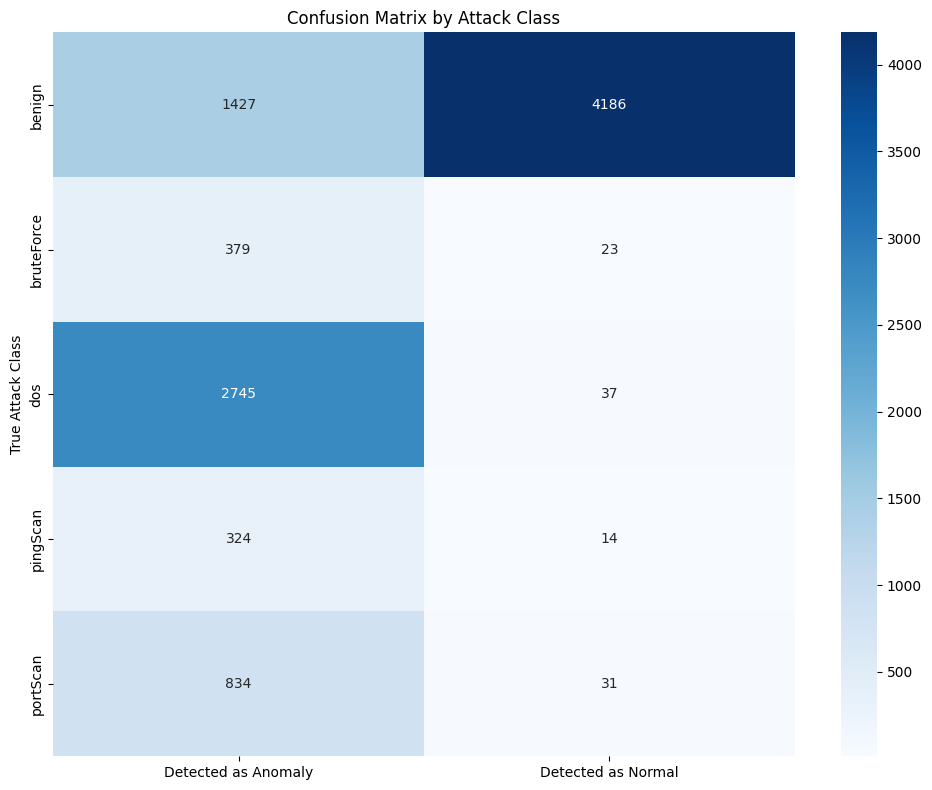

In [34]:
def create_multiclass_cm(y_true_class, y_pred_binary):
    """
    Create a confusion matrix showing how each attack class was classified.

    For attack classes (DoS, Probe, R2L, U2R), correct detection is when y_pred = -1 (anomaly)
    For normal class, correct detection is when y_pred = 1 (normal)
    """
    classes = np.unique(y_true_class)
    cm = np.zeros((len(classes), 2))

    for i, cls in enumerate(classes):
        # Get predictions for this class
        cls_indices = y_true_class == cls
        preds = y_pred_binary[cls_indices]

        # Count correct and incorrect predictions
        if cls == "normal":
            cm[i, 0] = np.sum(preds == -1)  # incorrectly detected as anomaly
            cm[i, 1] = np.sum(preds == 1)  # correctly detected as normal
        else:
            cm[i, 0] = np.sum(preds == -1)  # correctly detected as anomaly
            cm[i, 1] = np.sum(preds == 1)  # incorrectly detected as normal

    return cm, classes


# Create and plot the multi-class confusion matrix
cm_multi, classes = create_multiclass_cm(y_test_class, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(
    cm_multi,
    annot=True,
    fmt="g",
    cmap="Blues",
    xticklabels=["Detected as Anomaly", "Detected as Normal"],
    yticklabels=classes,
)
plt.ylabel("True Attack Class")
plt.title("Confusion Matrix by Attack Class")
plt.tight_layout()
plt.show()

In [35]:
# Calculate detection rates for each class
print("Detection rates by class:")
class_metrics = {}
for cls in np.unique(y_test_class):
    # Get indices for this class
    class_indices = y_test_class == cls

    # True values and predictions for this class
    y_true_cls = y_test[class_indices]
    y_pred_cls = y_pred[class_indices]

    # Calculate metrics
    if cls == "Normal":
        # For normal class, we want to detect 1 (normal)
        correct = np.sum((y_pred_cls == 1))
        precision = precision_score(
            y_true_cls, y_pred_cls, pos_label=1, zero_division=0
        )
        recall = recall_score(y_true_cls, y_pred_cls, pos_label=1, zero_division=0)
    else:
        # For attack classes, we want to detect -1 (anomaly)
        correct = np.sum((y_pred_cls == -1))
        precision = precision_score(
            y_true_cls, y_pred_cls, pos_label=-1, zero_division=0
        )
        recall = recall_score(y_true_cls, y_pred_cls, pos_label=-1, zero_division=0)

    total = len(y_pred_cls)
    detection_rate = correct / total
    f1 = f1_score(
        y_true_cls, y_pred_cls, pos_label=-1 if cls != "Normal" else 1, zero_division=0
    )

    class_metrics[cls] = {
        "detection_rate": detection_rate,
        "precision": precision,
        "recall": recall,
        "f1_score": f1,
        "count": total,
        "correctly_detected": correct,
    }

    print(f"{cls}: {detection_rate:.4f} ({correct}/{total})")

Detection rates by class:
benign: 0.2542 (1427/5613)
bruteForce: 0.9428 (379/402)
dos: 0.9867 (2745/2782)
pingScan: 0.9586 (324/338)
portScan: 0.9642 (834/865)
